In [3]:
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langchain_community.tools import ShellTool
from langgraph.prebuilt import ToolNode
from typing import TypedDict, List
import os
from dotenv import load_dotenv

from github import Github
load_dotenv()


True

In [12]:
# Set up Groq LLM
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")  

llm = ChatGroq(
    model="meta-llama/llama-4-scout-17b-16e-instruct",
)

In [13]:
# Define the state
class CodeReviewState(TypedDict):
    repo_name: str
    pr_number: int
    code_changes: List[str]
    feedback: List[str]
    issues: List[str]
    suggestions: List[str]

In [14]:
# Fetch PR changes
def fetch_pr_changes(state: CodeReviewState):
    repo_name = state["repo_name"]
    pr_number = state["pr_number"]
    
    g = Github(os.getenv("GITHUB_TOKEN"))
    repo = g.get_repo(repo_name)
    pr = repo.get_pull(pr_number)
    
    files = pr.get_files()
    code_changes = []
    for file in files:
        if file.patch:
            code_changes.append(f"File: {file.filename}\n{file.patch}")
    
    return {"code_changes": code_changes}

# Define nodes
def analyze_bugs(state: CodeReviewState):
    code_changes = state["code_changes"]
    all_code = "\n\n".join(code_changes)
    
    prompt = f"""You are an expert code reviewer. Analyze the following code changes for bugs and logic errors.
Focus on: runtime errors, incorrect logic, edge cases, null pointers, infinite loops, and potential crashes.
Provide structured feedback with issues and suggestions.

Code changes:
{all_code}"""
    
    response = llm.invoke([SystemMessage(content="You are a code review expert."), HumanMessage(content=prompt)])
    analysis = response.content
    
    return {"feedback": [f"## Bugs & Logic Errors\n{analysis}"], "issues": [], "suggestions": []}

def analyze_security(state: CodeReviewState):
    code_changes = state["code_changes"]
    all_code = "\n\n".join(code_changes)
    
    prompt = f"""You are an expert code reviewer. Analyze the following code changes for security vulnerabilities.
Focus on: injection risks, insecure APIs, access control, OWASP top 10, input validation, and safe practices.
Provide structured feedback with issues and suggestions.

Code changes:
{all_code}"""
    
    response = llm.invoke([SystemMessage(content="You are a code review expert."), HumanMessage(content=prompt)])
    analysis = response.content
    
    return {"feedback": [f"## Security Vulnerabilities\n{analysis}"], "issues": [], "suggestions": []}

def analyze_performance(state: CodeReviewState):
    code_changes = state["code_changes"]
    all_code = "\n\n".join(code_changes)
    
    prompt = f"""You are an expert code reviewer. Analyze the following code changes for performance and efficiency.
Focus on: bottlenecks, memory leaks, inefficient algorithms, large loops, resource usage, and scalability.
Provide structured feedback with issues and suggestions.

Code changes:
{all_code}"""
    
    response = llm.invoke([SystemMessage(content="You are a code review expert."), HumanMessage(content=prompt)])
    analysis = response.content
    
    return {"feedback": [f"## Performance & Efficiency\n{analysis}"], "issues": [], "suggestions": []}

def analyze_style(state: CodeReviewState):
    code_changes = state["code_changes"]
    all_code = "\n\n".join(code_changes)
    
    prompt = f"""You are an expert code reviewer. Analyze the following code changes for code style and best practices.
Focus on: naming conventions, indentation, readability, framework guidelines, and maintainability.
Provide structured feedback with issues and suggestions.

Code changes:
{all_code}"""
    
    response = llm.invoke([SystemMessage(content="You are a code review expert."), HumanMessage(content=prompt)])
    analysis = response.content
    
    return {"feedback": [f"## Code Style & Best Practices\n{analysis}"], "issues": [], "suggestions": []}

def analyze_testing(state: CodeReviewState):
    code_changes = state["code_changes"]
    all_code = "\n\n".join(code_changes)
    
    prompt = f"""You are an expert code reviewer. Analyze the following code changes for testing and coverage.
Focus on: test quality, coverage gaps, flaky tests, missing edge cases, and testing best practices.
Provide structured feedback with issues and suggestions.

Code changes:
{all_code}"""
    
    response = llm.invoke([SystemMessage(content="You are a code review expert."), HumanMessage(content=prompt)])
    analysis = response.content
    
    return {"feedback": [f"## Testing & Coverage\n{analysis}"], "issues": [], "suggestions": []}

def aggregate_results(state: CodeReviewState):
    # Combine all feedback into one
    combined_feedback = "\n\n".join(state["feedback"])
    return {"feedback": [combined_feedback]}

def provide_feedback(state: CodeReviewState):
    # The feedback is already aggregated
    # Format it professionally for GitHub
    feedback = state["feedback"][0] if state["feedback"] else "No feedback generated."
    
    # Add a professional header
    professional_feedback = f"""## 🤖 AI Code Review Analysis

{feedback}

---
*This review was generated automatically by the SmartReview AI agent. Please review the suggestions and address any critical issues before merging.*"""
    
    return {"feedback": [professional_feedback]}

def post_feedback(state: CodeReviewState):
    repo_name = state["repo_name"]
    pr_number = state["pr_number"]
    feedback = state["feedback"][0] if state["feedback"] else "No feedback generated."
    
    g = Github(os.getenv("GITHUB_TOKEN"))
    repo = g.get_repo(repo_name)
    pr = repo.get_pull(pr_number)
    
    pr.create_issue_comment(feedback)
    return {}

In [15]:
# Build the graph
graph = StateGraph(CodeReviewState)

graph.add_node("fetch_pr", fetch_pr_changes)
graph.add_node("analyze_bugs", analyze_bugs)
graph.add_node("analyze_security", analyze_security)
graph.add_node("analyze_performance", analyze_performance)
graph.add_node("analyze_style", analyze_style)
graph.add_node("analyze_testing", analyze_testing)
graph.add_node("aggregate", aggregate_results)
graph.add_node("feedback", provide_feedback)
graph.add_node("post", post_feedback)


graph.add_edge(START, "fetch_pr")
graph.add_edge("fetch_pr", "analyze_bugs")
graph.add_edge("fetch_pr", "analyze_security")
graph.add_edge("fetch_pr", "analyze_performance")
graph.add_edge("fetch_pr", "analyze_style")
graph.add_edge("fetch_pr", "analyze_testing")
graph.add_edge("analyze_bugs", "aggregate")
graph.add_edge("analyze_security", "aggregate")
graph.add_edge("analyze_performance", "aggregate")
graph.add_edge("analyze_style", "aggregate")
graph.add_edge("analyze_testing", "aggregate")
graph.add_edge("aggregate", "feedback")
graph.add_edge("feedback", "post")
graph.add_edge("post", END)

code_review_agent = graph.compile()

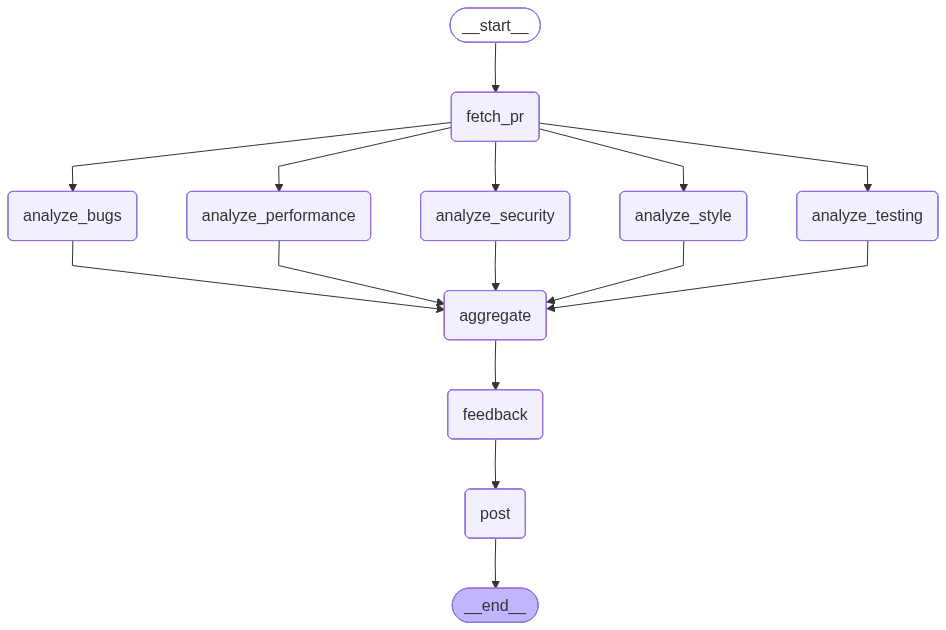

In [18]:
from IPython.display import display, Image
display(Image( code_review_agent.get_graph().draw_mermaid_png(max_retries=5, retry_delay=2.0)))

In [9]:
# Test the agent with PR
# Example: repo_name = "owner/repo", pr_number = 1
result = code_review_agent.invoke({
    "repo_name": "shrivarshapoojari/SmartReview",  # Replace with actual repo
    "pr_number": 1,  # Replace with actual PR number
    "code_changes": [],
    "feedback": [],
    "issues": [],
    "suggestions": []
})

# Display the result in a readable way
print("=== Code Review Agent Result ===")
print(f"Repository: {result.get('repo_name', 'N/A')}")
print(f"PR Number: {result.get('pr_number', 'N/A')}")
print("\n--- Code Changes ---")
for i, change in enumerate(result.get('code_changes', []), 1):
    print(f"{i}. {change[:100]}...")  # 
print("\n--- Issues ---")
for issue in result.get('issues', []):
    print(f"- {issue}")
print("\n--- Suggestions ---")
for suggestion in result.get('suggestions', []):
    print(f"- {suggestion}")
print("\n--- Feedback ---")
for feedback in result.get('feedback', []):
    print(feedback)

C:\Users\shree\AppData\Local\Temp\ipykernel_33488\428173092.py:6: DeprecationWarning: Argument login_or_token is deprecated, please use auth=github.Auth.Token(...) instead
  g = Github(os.getenv("GITHUB_TOKEN"))
C:\Users\shree\AppData\Local\Temp\ipykernel_33488\428173092.py:56: DeprecationWarning: Argument login_or_token is deprecated, please use auth=github.Auth.Token(...) instead
  g = Github(os.getenv("GITHUB_TOKEN"))
C:\Users\shree\AppData\Local\Temp\ipykernel_33488\428173092.py:56: DeprecationWarning: Argument login_or_token is deprecated, please use auth=github.Auth.Token(...) instead
  g = Github(os.getenv("GITHUB_TOKEN"))


=== Code Review Agent Result ===
Repository: shrivarshapoojari/SmartReview
PR Number: 1

--- Code Changes ---
1. File: research/research.ipynb
@@ -2,7 +2,7 @@
  "cells": [
   {
    "cell_type": "code",
-   "execut...
2. File: test.py
@@ -0,0 +1,53 @@
+from flask import Flask, request, render_template_string
+import sql...

--- Issues ---

--- Suggestions ---

--- Feedback ---
## 🤖 AI Code Review Analysis

**1. Executive summary**  
Top 5 issues (ranked by severity and effort to fix):  

| Rank | Issue | One‑liner remediation |
|------|-------|-----------------------|
| 1 | **SQL Injection** in `/login` | Use parameterised queries (e.g., `cursor.execute("SELECT … WHERE …", (username, password))`). |
| 2 | **Cross‑Site Scripting** in `/search` | Escape or template‑render user input instead of interpolating it into `render_template_string`. |
| 3 | **Missing CSRF protection** on the POST login form | Add Flask‑WTF CSRF token or `@app.before_request` guard. |
| 4 | **Debug mode enabled** (

In [11]:
# Display the graph
 